In [198]:
import sys, os, time
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# %load_ext autoreload
# %autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim as O
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision
from torch.utils.data import Dataset, DataLoader
import gym
from tqdm import tqdm_notebook as tqdm
import inspect
import numpy as np
import h5py as hf
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import seaborn as sns
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train
from foundation import sim as SIM
#from foundation.util import replicate, Cloner
from scipy import stats
np.set_printoptions(linewidth=120)

In [131]:
torchvision.datasets.CelebA?

In [187]:
# celeba

dataset = torchvision.datasets.CelebA(os.path.join(os.environ['FOUNDATION_DATA_DIR']), download=False, 
#                                       transform=torchvision.transforms.ToTensor(), 
                                      transform=None, target_type='identity',
                                      split='all')
len(dataset)

202599

In [188]:
x, y = dataset[0]
type(x)

PIL.JpegImagePlugin.JpegImageFile

In [189]:
img = np.array(x)
img.shape, img.dtype

((218, 178, 3), dtype('uint8'))

In [190]:
y

tensor(2880)

In [25]:
s = util.rgb_to_str(img)
len(s)

58563

In [40]:
type(s)

bytes

In [91]:
np.product(img.shape) * 202599 // 1e6

23584.0

In [39]:
ab = [bytes(a) for a in attrs]
len(ab)

TypeError: string argument without an encoding

In [205]:
full_path = os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'celeba_train.h5')
full_path

'/is/ei/fleeb/workspace/local_data/celeba/celeba_train.h5'

In [175]:
# with hf.File(full_path, 'w') as f:
#     f.attrs['attr_names'] = [a.encode('ascii', 'replace') for a in attrs]
#     f.create_dataset('images', data=[s, s])

In [176]:
# f = hf.File(full_path, 'r')
# list(f.keys())

In [177]:
# f['images'].shape

In [178]:
# list(f.attrs)

In [179]:
# aload = f.attrs['attr_names']
# sload = f['images'][()]

In [180]:
# f.close()

In [181]:
# aload

In [206]:
# idents
with open(os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'identity_CelebA.txt'), 'r') as f:
    lines = f.readlines()
idents = np.array([int(l.split()[1]) for l in lines])
idents = idents.astype(np.int16)
idents.shape, idents.dtype, sys.getsizeof(idents)

((202599,), dtype('int16'), 405294)

In [207]:
# eval portion
train, test = [], []
with open(os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'list_eval_partition.txt'), 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        _, cat = line.split()
        if cat == '0':
            train.append(i)
        else:
            test.append(i)
train = np.array(train).astype(np.int32)
test = np.array(test).astype(np.int32)
total = len(train) + len(test)
len(train)/total, len(test)/total, total

(0.8034096910646153, 0.19659030893538468, 202599)

In [208]:
# landmarks
with open(os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'list_landmarks_align_celeba.txt'), 'r') as f:
    lines = f.readlines()
    lmark_names = lines[1].split()
    lines = lines[2:]
lmarks = np.stack([np.array(l.split()[1:]).astype(np.uint8) for l in lines])
# lmarks = lmarks.astype(np.uint8)
lmarks.shape, lmarks.dtype, sys.getsizeof(lmarks), len(lmark_names)

((202599, 10), dtype('uint8'), 2026102, 10)

In [209]:
# attrs
with open(os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'list_attr_celeba.txt'), 'r') as f:
    lines = f.readlines()
    attr_names = lines[1].split()
    lines = lines[2:]
attrs = np.stack([np.array(l.split()[1:]).astype(np.int8) for l in lines])
attrs += 1
attrs //= 2
attrs = attrs.astype(np.uint8)
attrs.shape, attrs.dtype, sys.getsizeof(attrs), len(attr_names)

((202599, 40), dtype('uint8'), 8104072, 40)

In [215]:
full_path = os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'celeba_train.h5')
full_path

'/is/ei/fleeb/workspace/local_data/celeba/celeba_train.h5'

In [211]:
with hf.File(full_path, 'w') as f:
    f.attrs['attr_names'] = [a.encode('ascii', 'replace') for a in attr_names[:len(train)]]
    f.attrs['landmark_names'] = [a.encode('ascii', 'replace') for a in lmark_names[:len(train)]]
    f.attrs['image_encoding'] = 'jpg'
#     f.create_dataset('eval_idx', data=test)
    f.create_dataset('attrs', data=attrs[:len(train)])
    f.create_dataset('landmarks', data=lmarks[:len(train)])
    f.create_dataset('identities', data=idents[:len(train)])

In [212]:
full_path = os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'celeba_test.h5')
full_path

'/is/ei/fleeb/workspace/local_data/celeba/celeba_test.h5'

In [213]:
with hf.File(full_path, 'w') as f:
    f.attrs['attr_names'] = [a.encode('ascii', 'replace') for a in attr_names[len(train):]]
    f.attrs['landmark_names'] = [a.encode('ascii', 'replace') for a in lmark_names[len(train):]]
#     f.create_dataset('eval_idx', data=test)
    f.create_dataset('attrs', data=attrs[len(train):])
    f.create_dataset('landmarks', data=lmarks[len(train):])
    f.create_dataset('identities', data=idents[len(train):])

In [199]:
def convert(i):
    img, _ = dataset[i]
    s = util.rgb_to_str(np.array(img))
    return s

In [200]:
all_s = []
farmer = util.Farmer(convert, volatile_gen=({'i':i} for i in range(len(train))), num_workers=8)
for s in tqdm(farmer, total=len(dataset)):
    all_s.append(s)
len(all_s)

202599

In [ ]:
os.path.isfile(os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'img_align_celeba', '000001.jpg'))

In [300]:
lpath = os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'img_align_celeba', '000001.jpg')
limg = Image.open(open(lpath, 'rb'))
with open(lpath, 'rb') as f:
    lbts = f.read()
len(lbts)

11440

In [301]:
os.path.getsize(lpath)

11440

In [294]:
from io import BytesIO # "import StringIO" directly in python2
from PIL import Image
 
buffer = BytesIO()
x.save(buffer, "JPEG", quality=100)

In [295]:
bts = buffer.getvalue()
len(bts)

32034

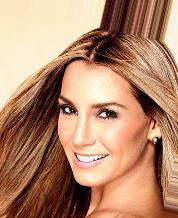

In [296]:
x

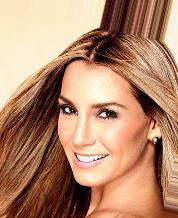

In [304]:
z = np.array(Image.open(BytesIO(lbts)))
reca = np.array(z)
z

In [216]:
with hf.File(full_path, 'r+') as f:
    f.create_dataset('images', data=all_s[:len(train)])

MemoryError: 

In [217]:
list(map(len,all_s[:10]))

[72743, 58978, 54015, 78991, 58563, 37956, 57654, 53909, 38048, 56081]

In [303]:
root = os.path.join(os.environ['FOUNDATION_DATA_DIR'], 'celeba', 'img_align_celeba')
[os.path.getsize(os.path.join(root, x)) for x in sorted(os.listdir(root))[:10]]

[11440, 7448, 4253, 10747, 6351, 8073, 8203, 7725, 8641, 7003]

In [220]:
np.product(img.shape)

116412

In [232]:
len(all_s)

202599